# Lista de Exercícios \#5
## Breno Vieira Arosa

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

from functools import partial

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams.update({'font.size': 14})

## Questão 1

In [3]:
def ackley(x):
    a = np.sqrt((x**2).mean(axis=1))
    b = (np.cos(2 * np.pi * x)).mean(axis=1)
    
    return -20 * np.exp(-.2 * a) - np.exp(b) + 20 + np.e

In [87]:
class EP(object):
    
    def __init__(self, individual_dimension, population_size, fitness_func):
        self.population_size = population_size
        self.individual_dimension = individual_dimension
        self.fitness_func = fitness_func
        
        self.population = self.init_population()
    
    
    def init_population(self):
        """
        Initialize population.
        """
        
        population = pd.DataFrame()
        
        #x0 = np.random.normal(loc=0, scale=1, size=(self.population_size, self.individual_dimension))
        x0 = np.random.uniform(low=-30, high=30, size=(self.population_size, self.individual_dimension))
        sigma0 = np.random.uniform(low=0, high=1, size=(self.population_size, self.individual_dimension))
        return {"x": x0, "sigma": sigma0}
    
    
    def evaluate(self, x):
        return -self.fitness_func(x)
    
    
    def mutate(self, population, alfa=.2, sigma_eps=0.03):
        """
        Gaussian Mutation - sigma first.
        """
        
        n = population["x"].shape[0]
        
        # one gaussian variable per individual
        sigma = population["sigma"] * np.random.normal(loc=1, scale=alfa, size=n).reshape(-1, 1)
        sigma[sigma < sigma_eps] = sigma_eps
        
        x = population["x"] + np.random.normal(loc=0, scale=sigma, size=(n, self.individual_dimension))

        
        return {"x": x, "sigma": sigma}

    
    def natural_selection(self, parents, offspring, q=10):
        """
        Tournament Competition.
        """
        
        # union parents and offspring
        population = {}
        population["x"] = np.vstack((parents["x"], offspring["x"]))
        population["sigma"] = np.vstack((parents["sigma"], offspring["sigma"]))
        
        # caches all fitness values
        fitness = self.evaluate(population["x"])
        tournament_scores = pd.DataFrame({"fitness": fitness, "wins": None})
        
        n = population["x"].shape[0]
        
        for i in range(n):
            # select opponents without selecting itself
            possible_opponents = tournament_scores.index[tournament_scores.index != i]
            opponents =  np.random.choice(possible_opponents, replace=False, size=q)
            
            # count how many wins individual have in its group
            tournament_scores.loc[i, "wins"] = (tournament_scores.loc[i, "fitness"] > tournament_scores.loc[opponents, "fitness"]).sum()
        
        most_wins = tournament_scores.nlargest(self.population_size, "wins", keep="last")
        
        x = population["x"][most_wins.index]
        sigma = population["sigma"][most_wins.index]
        
        return {"x": x, "sigma": sigma}

    
    def evolve(self):
        offspring = self.mutate(self.population)
        self.population = self.natural_selection(self.population, offspring)
        return

In [91]:
ep = EP(30, 1000, ackley)

In [92]:
N = 500

history = np.zeros((N, ep.population_size, ep.individual_dimension))
for i in range(N):
    history[i, :, :] = ep.population["x"].copy()
    ep.evolve()

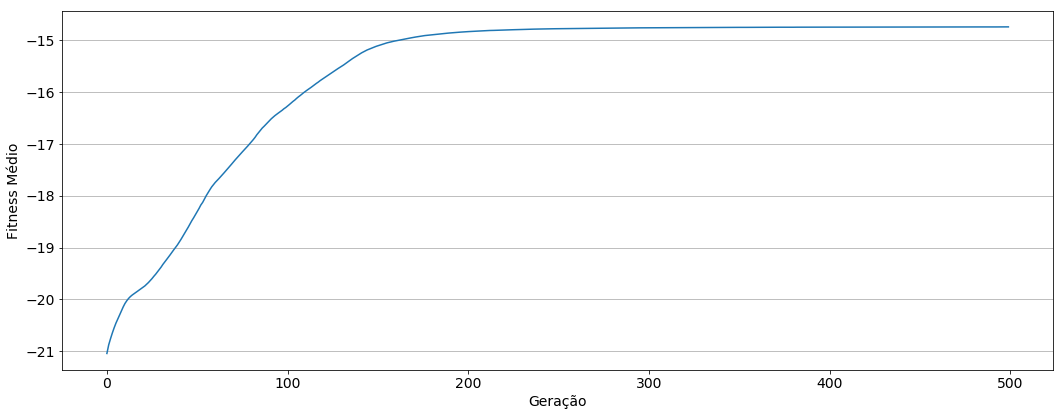

In [93]:
history_mean = np.zeros((N))
history_min = np.zeros((N))
history_max = np.zeros((N))
for i in range(N):
    fitness = es.evaluate(history[i, :, :])
    fitness.std()
    history_mean[i] = fitness.mean()
    history_min[i] = fitness.min()
    history_max[i] = fitness.max()

plt.figure(figsize=(15, 6))

#plt.fill_between(np.linspace(0, N-1, N), history_min, history_max, alpha=.2)
plt.plot(np.linspace(0, N-1, N), history_mean)

plt.ylabel("Fitness Médio")
plt.xlabel("Geração")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [82]:
ep.population["x"].mean(axis=0)

array([-6.16411768e-03,  1.99402078e+00,  4.98692991e+00,  7.98240214e+00,
       -3.00025470e+00, -1.22026750e-02, -6.98556801e+00,  3.99711052e+00,
       -4.98399549e+00, -1.00308697e+00,  7.98553778e+00,  9.90155707e-01,
        6.86343683e-03,  4.99250261e+00, -1.99023063e+00,  2.99030717e+00,
       -3.50839114e-03, -3.97074302e+00, -9.86919104e-01, -9.95970636e-01,
        1.00124122e+00,  9.99403764e+00,  8.73512902e-03, -2.29479236e+01,
        6.83732629e-03,  1.99317394e+00, -9.94759354e-01,  2.99368968e+00,
        7.89752016e-04, -4.99739870e+00])

## Questão 2
### Consider using the number of generations as a measure to establish the speed of an EA. Compare the use of this measure with using the number of fitness evaluations.

O uso de gerações para avaliar a velocidade dos algoritmos evolucionarios não é uma medida confiavél.
Isto acontece porque diferentes fatores podem afetar o tempo de execução.
Por exemplo, o número de indivíduos, a escolha do algoritmo de seleção de pais, entre outros.
Em geral, a availação da função fitness é a parte computacionalmente mais custosa do algoritmo, portanto, o número de avaliações da função fitness se torna uma boa métrica de velocidade para os algoritmos evolucionarios.

## Questão 3

### Give the arguments why mutation strength (e.g., pm or sigma) should be increased during a run. Give arguments why it should be decreased

Existem dois conceitos importantes para algoritmos de otimização: "exploitation" e "exploration".
"Exploration" representa a capacidade do algoritmo de explorar diferentes regiões e/ou soluções de um problema.
Enquanto "exploitation" é a concentração das buscas nas regiões de bons resultados conhecidos.

Geralmente, a etapa de mutação tem como objetivo aumentar o "exploration", forçando o algoritmo a buscar novas soluções.
Porém, variações como Programação Evolucionária dependem apenas das mutações para evolução, ficando estas responsáveis também para fase de "exploitation".

Portanto, o uso de fortes mutações, tanto por pm quanto por sigma, é indicado na fase exploratória do algoritmo.
Essa fase normalmente ocupa o início das execuções mas também pode ser utilizada quando se convergir a algum mínimo.
A fase de exploração pode ser mais eficientes utilizando baixos valores de mutação.
Sendo assim, é interessante se começar o algoritmo com altos valores de mutação e ir decrescendo esses índices a medida que se busca refinar a região de mínimo encontrada.

In [ ]:
class SGA(object):
    
    def __init__(self, binary_size, population_size,
                 fitness_func, mutation_rate):
        self.binary_size = binary_size
        self.population_size = population_size
        self.fitness_func = fitness_func
        self.mutation_rate = mutation_rate
        
        self.population = self.init_population()
    
    
    def repr_str2matrix(self, population):
        """
        Represent population as a 2D matrix.
        """
        arr = np.zeros((len(population), self.binary_size)).astype("uint8")
        for i, x in enumerate(sga.population):
            arr[i, :] = np.array(list(x)).astype("uint8")
        return arr
    
    
    def repr_matrix2str(self, population):
        """
        Represent population as a vector of binary strings.
        """
        population = population.astype(int)
        matrix2str = lambda x: "".join(map(str, x))
        return np.apply_along_axis(matrix2str, axis=1, arr=population)
    
    
    def init_population(self):
        """
        Initialize binary vectors.
        """
        x0 = np.random.randint(low=0, high=2,
                               size=(self.population_size, self.binary_size),
                               dtype="uint8")
        return x0
    
    
    def evaluate(self, population):
        return self.fitness_func(population)
    
    
    def mutate(self, rate):
        """
        Bitwise Mutation.
        
        Mutate bits with given rate.
        """
        population = self.population.copy().astype(bool)
        mutation_rand = np.random.uniform(size=(self.population_size, self.binary_size))
        
        # invert bit if random sample < mutation rate
        population[mutation_rand < rate] = ~population[mutation_rand < rate]
        return population.astype("uint8")
    
    
    def recombine(self, parents):
        """
        One-Point Crossover.
        
        The formation of pairs are randomized.
        100% children are formed from recombination (crossover rate = 1).
        The point of crossover is randomized for each pair.
        Two children are created per pair of parents.
        """
        
        # shuffle parents before form pairs
        parents = parents.copy()
        np.random.shuffle(parents)
        
        # form pairs of parents
        parents = parents.reshape(-1, 2, self.binary_size)
                
        # defines the multiplier pattern to match crossover
        cross_multiplier = np.ones((parents.shape[0], 2, self.binary_size), dtype="uint8")
        for i in range(parents.shape[0]):
            # defines the point of crossover
            # there is no crossover if point equals 0 or (binary_size-1)
            cross_idx = np.random.randint(low=1, high=(self.binary_size - 2))
            cross_multiplier[i, 0, cross_idx:self.binary_size] = 0
            cross_multiplier[i, 1, 0:cross_idx] = 0
        
        # multipliers parent pairs by crossover pattern and anti-pattern
        # developing the same number of children as parents
        children_top = (parents * cross_multiplier).sum(axis=1)
        children_bot = (parents * (~cross_multiplier.astype(bool)).astype("uint8")).sum(axis=1)
        children = np.vstack((children_top, children_bot))
        
        return children

                             
    def parent_selection(self, s=1.5):
        """
        Generational model.
        Linear Ranking Selection with Roullete Wheel probabilities.
        """
        
        fitness = self.evaluate(self.population)
        rank = stats.rankdata(fitness, "ordinal")
        u = self.population_size     
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)

        return self.population[select_idx, :]

    
    def natural_selection(self, parents, children, s=1.5):
        """
        Fitness-Based Replacement.
        Linear Ranking Selection with Roullete Wheel probabilities
        """
        population = np.concatenate((parents, children))
        
        fitness = self.evaluate(population)
        rank = stats.rankdata(fitness, "ordinal")
        u = len(population)   
        
        p = ((2 - s) / u) + ((2 * rank * (s-1)) / (u * (u - 1)))
        p = p / p.sum()
        
        select_idx = np.random.choice(np.linspace(0, (u-1), u),
                                      size=self.population_size,
                                      replace=True, p=p).astype(int)
        
        return population[select_idx, :]

    
    def evolve(self):
        parents = self.parent_selection(s=1.5)
        offspring = self.recombine(parents)
        offspring = self.mutate(self.mutation_rate)
        self.population = self.natural_selection(parents, offspring, s=1.5)
        return